In [1]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import EvaluationModule
pd.options.mode.chained_assignment = None

(CVXPY) Jul 12 10:48:24 AM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 12 10:48:24 AM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 12 10:48:24 AM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="binary_classification", #option: regression, regression_delta, classification, binary_classification
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation="IterativeImputer", #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    remove_low_DAS = True,
    save_csv=False,
    balance_class=True,
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Missing values in train before imputation: 128
Missing values in train after imputation: 0
Missing values in test before imputation: 24
Missing values in test after imputation: 0
Label Encoder, 0: Non-responders (No Response), 1: Responders(Good, Moderate)
Label Encoder, 0: Non-responders (No Response), 1: Responders(Good, Moderate)
before balance class: 1.0    231
0.0     73
Name: DrugResponse_binary, dtype: int64
after balance class: 1.0    204
0.0    184
Name: DrugResponse_binary, dtype: int64
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Train.csv
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Test.csv


In [4]:
train_set, train_loc = dataset.get_train()
test_set, test_loc = dataset.get_test()

In [5]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train_h2o = h2o.upload_file(str(train_loc))
test_h2o = h2o.upload_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns
y = "DrugResponse_binary"
x.remove(y)

predictors = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
response = "DrugResponse_binary"

for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
train_h2o[response] = train_h2o[response].asfactor()
test_h2o[response] = test_h2o[response].asfactor()

train, valid = train_h2o.split_frame(ratios=[.8], seed=1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/tmp_2r8el94
  JVM stdout: /var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/tmp_2r8el94/h2o_gaskell_started_from_python.out
  JVM stderr: /var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/tmp_2r8el94/h2o_gaskell_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_gaskell_kfhrdp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
# DRF hyperparameters
drf_params = {'ntrees': [i * 10 for i in range(1,101)],
               'max_depth': list(range(2,20)),
               'min_rows': [1,5,10,15],
               'sample_rate': [i * 0.1 for i in range(5, 11)],
}

search_criteria = {'strategy': 'RandomDiscrete', 'seed':1,
                   'max_models':25, 'max_runtime_secs': 1200,
                   'stopping_metric': 'auc',
                   'stopping_tolerance': 0.05, 'stopping_rounds': 10}

In [15]:
# Train and validate a cartesian grid of GBMs
drf_grid1 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid',
                          hyper_params=drf_params,
                          search_criteria=search_criteria)

In [16]:
drf_grid1.train(x=x, y=y,
                nfolds=10,
                training_frame=train,
                validation_frame=valid,
                binomial_double_trees=True,
                seed=1)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
      max_depth  min_rows  ntrees  sample_rate          model_ids   logloss
0          10.0       1.0   350.0          0.9   drf_grid_model_2  0.422736
1          17.0       1.0   480.0          0.8   drf_grid_model_1  0.424578
2          14.0       1.0   640.0          0.8   drf_grid_model_9  0.424835
3          10.0       1.0   370.0          0.6  drf_grid_model_14  0.456374
4          15.0       1.0   180.0          0.5  drf_grid_model_23  0.462291
5          16.0       5.0   990.0          1.0   drf_grid_model_7  0.474605
6           7.0       5.0   600.0          0.9  drf_grid_model_18  0.495680
7           5.0       5.0   800.0          1.0  drf_grid_model_22  0.523285
8          18.0      10.0    90.0          0.9  drf_grid_model_17  0.525043
9          12.0      10.0   530.0          0.8  drf_grid_model_13  0.531069
10         11.0      10.0   760.0          0.7  drf_grid_model_10  0.

In [17]:
drf_gridperf = drf_grid1.get_grid(sort_by='auc', decreasing=True)
drf_gridperf

      max_depth  min_rows  ntrees  sample_rate          model_ids       auc
0          14.0       1.0   640.0          0.8   drf_grid_model_9  0.918818
1          17.0       1.0   480.0          0.8   drf_grid_model_1  0.917949
2          10.0       1.0   350.0          0.9   drf_grid_model_2  0.916377
3          15.0       1.0   180.0          0.5  drf_grid_model_23  0.907378
4          10.0       1.0   370.0          0.6  drf_grid_model_14  0.906778
5          16.0       5.0   990.0          1.0   drf_grid_model_7  0.892337
6           7.0       5.0   600.0          0.9  drf_grid_model_18  0.882903
7           5.0       5.0   800.0          1.0  drf_grid_model_22  0.867718
8          18.0      10.0    90.0          0.9  drf_grid_model_17  0.858408
9          12.0      10.0   530.0          0.8  drf_grid_model_13  0.858325
10         11.0      10.0   760.0          0.7  drf_grid_model_10  0.852491
11         12.0      10.0   700.0          0.6   drf_grid_model_3  0.848850
12          

In [18]:
best_drf = drf_gridperf.models[0]

In [19]:
best_drf_perf = best_drf.model_performance(test_h2o)
best_drf_perf.auc()

0.6679999999999999

In [20]:
best_drf_perf.accuracy()

[[0.4224416482274927, 0.7176470588235294]]

In [26]:
# # Build and train the model:
# RAdrugs_drf = H2ORandomForestEstimator(
#     nfolds = 5,
#     ntrees = 100,
#     max_depth = 20,
#     min_rows=10,
# #     balance_classes = True,
# #     max_after_balance_size = 1.0,
# #     calibrate_model=True,
# #     calibration_frame=valid,
#     histogram_type="Random",
#     binomial_double_trees=True)

In [21]:
# RAdrugs_drf.train(x=predictors,
#                   y=response,
#                   training_frame=train,
#                   validation_frame=valid)

In [23]:
# Eval performance:
# perf = best_drf_perf.model_performance()

In [24]:
# perf

In [25]:
# Generate predictions on a validation set (if necessary):
pred = best_drf.predict(test_h2o)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [26]:
pred

predict,p0,p1
1,0.290997,0.709003
1,0.364839,0.635161
1,0.168036,0.831964
1,0.356215,0.643785
1,0.351137,0.648863
1,0.342092,0.657908
1,0.183386,0.816614
1,0.56291,0.43709
1,0.311469,0.688531
1,0.262197,0.737803


In [27]:
test_h2o

grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,drinker,drinksperwk,duration_ra,ara_func_class,num_tnf,num_nontnf,ndmardused,rfstatus_b,usresultsRF,ccpstatus_b,usresultsCCP3,hxmi,hxunstab_ang,hxchf,hxother_cv,hxtia,hxstroke,hxcopd,hxhtn,hxdiabetes,hxhld,hx_anycancer,seatedbp1,seatedbp2,pres_mtx,pres_arava,pres_azulfidine,pres_plaquenil,pres_imuran,pres_minocin,pres_pred,nonpresNSAIDs_use,NSAIDs_use,tender_jts_28,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DrugResponse_binary
0,0,62,1,0,7,1,219,28.1149,74,2,2,7,1,0,0,0,1,0,8.7,0,16,0,0,0,0,0,0,0,0,0,0,0,110,71,1,0,0,0,0,0,0,0,0,5,3,35,10,0,10,4.41,284,1640,94,3.44494,1
1,0,54,0,2,7,1,160,26.6225,65,0,1,0,3,1,0,0,2,1,28.8,1,251,0,0,0,0,0,0,0,0,0,0,0,140,82,0,0,0,0,0,0,0,1,0,7,7,65,70,0.75,60,51.51,462,939,49,5.58839,1
1,0,42,1,0,7,1,185,26.5418,70,3,2,28,1,0,0,0,1,1,215.6,1,251,0,0,0,0,0,0,0,0,0,0,0,137,80,1,0,0,0,0,0,0,1,0,5,8,39,35,0,35,5.3,231,1340,118,4.15676,1
2,0,72,0,2,7,1,152,24.5308,66,3,1,0,12,1,0,0,4,1,1450,1,251,0,0,0,0,0,0,0,1,0,0,0,182,100,0,0,0,1,0,0,1,0,0,5,6,50,65,0.857143,50,4.75,657,1480,317,4.43777,0
1,0,42,0,0,7,1,239,38.5714,66,2,1,0,2,1,0,0,3,1,16.3,1,29,0,0,0,0,0,0,0,1,0,1,0,130,80,0,0,0,0,0,0,0,0,1,4,3,50,57,0.75,63,56.12,192,1810,197,4.81923,1
2,0,48,0,0,7,1,208,34.6092,65,0,1,0,6,1,0,0,3,1,19.7,0,15,0,0,0,0,0,0,0,1,0,1,0,144,90,0,0,0,0,0,0,0,0,1,8,3,40,40,1,76,21.53,136,904,188,4.71024,1
2,0,51,0,2,7,1,92,16.8252,62,0,1,0,5,2,0,0,2,1,86,1,251,0,0,0,0,0,0,0,0,1,0,0,120,82,1,0,0,0,0,0,1,0,0,10,7,20,80,1.5,0,71.33,206,1040,192,6.13293,0
2,0,61,0,2,7,1,249,41.4312,65,0,1,0,0,1,0,0,1,1,107.9,1,251,0,0,0,0,0,0,0,1,0,0,0,140,78,1,0,0,0,0,0,0,1,0,8,5,30,20,0,6,4.97,249,1120,107,4.09325,1
1,0,38,1,0,7,1,161,27.6326,64,2,1,0,23,2,0,0,1,1,16.2,0,15,0,0,0,0,0,0,0,1,0,0,0,120,80,1,0,0,0,0,0,1,0,1,10,12,60,65,0.5,80,3.84,74,903,46,5.17851,1
1,0,26,1,2,7,2,248,32.7161,73,0,1,0,11,2,0,0,2,1,14.6,0,15,0,0,0,0,0,0,0,0,0,0,0,128,78,0,0,0,0,1,0,1,1,0,4,4,50,55,0.625,80,130.47,202,1010,56,5.16636,1


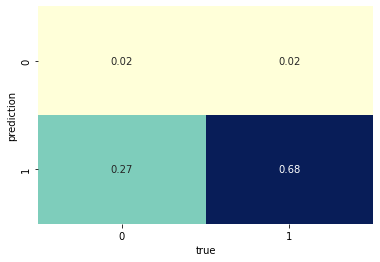

In [28]:
true = test_h2o.as_data_frame()['DrugResponse_binary']
pred = pred.as_data_frame()['predict']
EvaluationModule.confusion_matrix_scratch(true, pred, normalize=True, plot=True)